### Simulate RDD Data 

# Make some choices

Running this cell will define the variables of interest, our hyperparameters and some training options.

Make sure your Google Colab runtime has a GPU. You can turn this on via:

`Runtime -> Change Runtime type -> Hardware Accelerator -> GPU`

In [318]:
import wgan
import torch
import pandas as pd
from rdd import rdd 
import numpy as np
#assert torch.cuda.is_available()

# Y | X, t
cont = ["x","y"]
lbounda = {"x":0,"y":0}
ubounda = {'x':1,'y':1}
lboundb = {'x':-1,'y':0}
uboundb = {'x':0,'y':1}

Estimation Equation:	 y ~ TREATED + x


0.08522574425161496

### Lee data

In [319]:
n_a = sum(df['x']>0)
n_b = sum(df['x']<=0)

In [160]:
df['x'].min()

-1.0

In [330]:
context1

tensor([], size=(6558, 0))

In [125]:
x2a.shape

torch.Size([3818, 1])

In [331]:
file = "data/cleaned/lee.csv"
df = pd.read_csv(file)

dfa = df[df['x']>0].copy()
print(dfa.head())

dfb = df[df['x']<=0].copy()
print(dfa.head())

data_wrapper2a = wgan.DataWrapper(dfa,cont,continuous_lower_bounds=lbounda,
                                              continuous_upper_bounds=ubounda)

x2a,context2a = data_wrapper2a.preprocess(dfa)
specs2a = wgan.Specifications(data_wrapper2a,batch_size=256,max_epochs=750,
                              critic_d_hidden=[64,64,64],generator_d_hidden=[64,64,64],
                                     print_every=100,generator_dropout=0.1)
generator2a = wgan.Generator(specs2a)
critic2a = wgan.Critic(specs2a)


data_wrapper2b = wgan.DataWrapper(dfb,cont,continuous_lower_bounds=lboundb,
                                  continuous_upper_bounds=uboundb)
x2b,context2b = data_wrapper2b.preprocess(dfb)
specifications2b = wgan.Specifications(data_wrapper2b,batch_size=256,max_epochs=750,
                                       critic_d_hidden=[64,64,64],generator_d_hidden=[64,64,64],
                                     print_every=100,generator_dropout=0.1)
generator2b = wgan.Generator(specifications2b)
critic2b = wgan.Critic(specifications2b)

          x         y
0  0.104869  0.580962
1  0.139252  0.461058
3  0.086822  0.584580
4  0.399358  0.580286
5  0.168077  0.624352
          x         y
0  0.104869  0.780962
1  0.139252  0.661058
3  0.086822  0.784580
4  0.399358  0.780286
5  0.168077  0.824352
settings: {'critic_d_hidden': [64, 64, 64], 'critic_dropout': 0, 'critic_steps': 15, 'critic_lr': 0.0001, 'critic_gp_factor': 5, 'generator_d_hidden': [64, 64, 64], 'generator_dropout': 0.1, 'generator_lr': 0.0001, 'generator_d_noise': 2, 'gaussian_similarity_penalty': None, 'optimizer': 'AdamHD', 'max_epochs': 750, 'batch_size': 256, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint': None, 'save_every': 100, 'print_every': 100, 'device': 'cpu'}
settings: {'critic_d_hidden': [64, 64, 64], 'critic_dropout': 0, 'critic_steps': 15, 'critic_lr': 0.0001, 'critic_gp_factor': 5, 'generator_d_hidden': [64, 64, 64], 'generator_dropout': 0.1, 'generator_lr': 0.0001, 'generator_d_noise': 2, 'gaussian_similarity_penalty': No

Run the next cell to train the models. You can abort at any time to continue with the evaluation.

In [332]:
# Option 1: train from scratch
#wgan.train(generator1, critic1, x1, context1, specifications1)
wgan.train(generator2a, critic2a, x2a, context2a, specs2a)
wgan.train(generator2b, critic2b, x2b, context2b, specifications2b)

epoch 0 | step 16 | WD_test 0.04 | WD_train 0.02 | sec passed 0 |
epoch 100 | step 1516 | WD_test 1.04 | WD_train 0.96 | sec passed 11 |
epoch 200 | step 3016 | WD_test -0.11 | WD_train 0.18 | sec passed 11 |
epoch 300 | step 4516 | WD_test 0.2 | WD_train 0.25 | sec passed 11 |
epoch 400 | step 6016 | WD_test -0.22 | WD_train 0.1 | sec passed 11 |
epoch 500 | step 7516 | WD_test -0.45 | WD_train 0.07 | sec passed 11 |
epoch 600 | step 9016 | WD_test -0.1 | WD_train 0.05 | sec passed 11 |
epoch 700 | step 10516 | WD_test -0.04 | WD_train 0.03 | sec passed 11 |
epoch 0 | step 12 | WD_test 0.01 | WD_train 0.02 | sec passed 0 |
epoch 100 | step 1112 | WD_test 0.58 | WD_train 0.98 | sec passed 8 |
epoch 200 | step 2212 | WD_test 0.27 | WD_train 0.65 | sec passed 8 |
epoch 300 | step 3312 | WD_test 0.2 | WD_train 0.36 | sec passed 8 |
epoch 400 | step 4412 | WD_test 0.06 | WD_train 0.25 | sec passed 8 |
epoch 500 | step 5512 | WD_test 0.41 | WD_train 0.25 | sec passed 8 |
epoch 600 | step 66

Alternatively, you can load our pre-trained parameters:

In [0]:
# Option 2: load trained model parameters
def load_saved_parameters(type):
  for model, name in zip(G + C, ["G_0", "G_1", "C_0", "C_1"]):
      state_dict = torch.load("trained_models/" + name + "_{}.pth".format(type))
      model.load_state_dict(state_dict)

#load_saved_parameters("exp")

To get a simulated data frame, we use the `DataWrapper.apply_generator(generator, df)` method, which updates columns in `df` with data simulated from `generator` wherever possible. We can therefore chain multiple calls together to build up a fake dataframe from multiple (partial) generators.
Similarly, we can add a column with the values of the critic using the `DataWrapper.apply_critic(critic, df)` method.

We'll wrap everything into a function so that we can repeat later.

In [234]:
def apply_models_to_data():
    s = df.sample(int(1e4),replace=True)
    dfa = s[s['x']>0]
    dfb = s[s['x']<=0] 
    #first generate x 
    dfa = data_wrapper2a.apply_generator(generator2a,dfa)
    dfb = data_wrapper2b.apply_generator(generator2b,dfb)
    return pd.concat([dfa,dfb],axis=0,ignore_index=True)

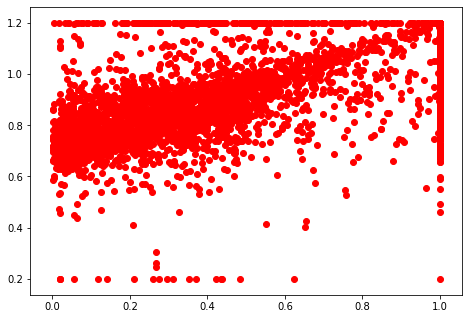

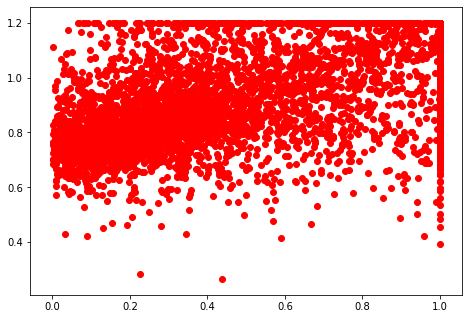

In [334]:
import matplotlib.pyplot as plt
fig=plt.figure() 
ax=fig.add_axes([0,0,1,1])
ax.scatter(df.loc[df['x']>0,'x'],df.loc[df['x']>0,'y']+0.2, color='r')
#ax.scatter(df.loc[df['x']<=0,'x'],df.loc[df['x']<=0,'y'], color='b')

fig2=plt.figure() 
ax=fig2.add_axes([0,0,1,1])
ax.scatter(df_fake.loc[df_fake['x']>0,'x'],df_fake.loc[df_fake['x']>0,'y'], color='r')
#ax.scatter(df_fake.loc[df_fake['x']<=0,'x'],df_fake.loc[df_fake['x']<=0,'y'], color='b')

In [235]:

df_fake.head()

,x,y
0,0.767735,0.796593
1,0.332971,0.591142
2,0.498043,0.635100
3,0.419456,0.726818
4,0.035995,0.479435


In [285]:
def rdd_estimate(data):
    bandwidth_opt = rdd.optimal_bandwidth(data['y'], data['x'], cut=0) 
    data_rdd = rdd.truncated_data(data, 'x', bandwidth_opt, cut=0) 
    model = rdd.rdd(data_rdd, 'x', 'y', cut=0)
    return model.fit().params[1]

Finally, we can examine our generated data with the `compare_dfs` function.


In [333]:
df_fake = apply_models_to_data()
rdd_estimate(df_fake)

Estimation Equation:	 y ~ TREATED + x


0.1653237301437024

In [337]:
def evaluate_results():
  # Let's print the att!
  print("--------------------RDD--------------------")
  print("real:",rdd_estimate(df)) 
  print("fake:",rdd_estimate(df_fake))

  # Now, we'll compare our fake data to the real data
  table_groupby = ["t"]
  scatterplot = dict(x= ["x"],
                     y= ["y"],
                     samples = 1000, smooth = 0)
  histogram = dict(variables=['x','y','x','y'],
                   nrow=2, ncol=2)
  wgan.compare_dfs(df, df_fake, figsize=5, histogram=histogram, scatterplot=scatterplot)


--------------------RDD--------------------
Estimation Equation:	 y ~ TREATED + x
real: 0.2852257442516214
Estimation Equation:	 y ~ TREATED + x
fake: 0.1653237301437024
-------------comparison of means-------------
source  fake  real
x       0.11  0.13
y       0.66  0.55
-------------comparison of stds-------------
source  fake  real
x       0.44  0.46
y       0.31  0.24


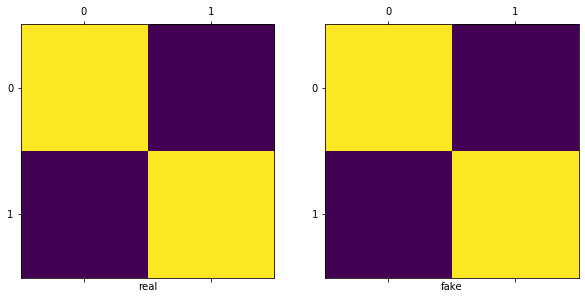

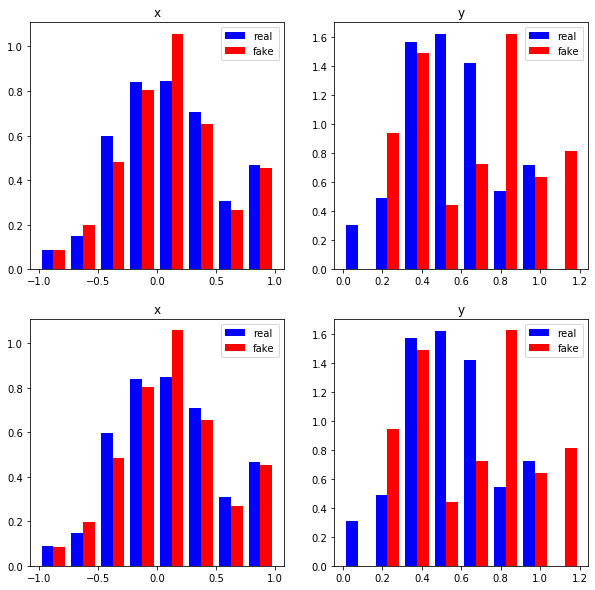

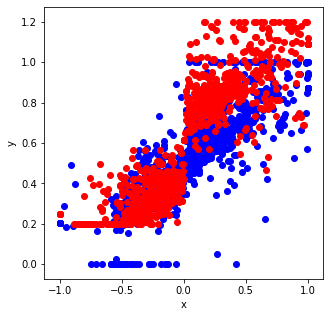

In [336]:
evaluate_results()

Looks good enough? Then save the models, generate a large dataframe and export it.

In [240]:
# save trained model parameters
def save_trained_parameters(type):
  #%mkdir trained_models
  for model, name in zip([generator2a,critic2a,generator2b,critic2b], ["Ga","Ca","Gb","Cb"]):
      torch.save(model.state_dict(), "trained_models/" + name + "_{}.pth".format(type))

In [241]:
save_trained_parameters("lee")

In [267]:
# generate and save data of a certain sample size
def save_generated_data(type,n_samples):
    s = df.sample(int(n_samples),replace=True)
    dfa = s[s['x']>0]
    dfb = s[s['x']<=0] 
    #first generate x 
    dfa = data_wrapper2a.apply_generator(generator2a,dfa)
    dfb = data_wrapper2b.apply_generator(generator2b,dfb)
    df_fake = pd.concat([dfa,dfb],axis=0,ignore_index=True)
    print(df_fake.head())
    print(rdd_estimate(df_fake))
    df_fake.to_feather("data/generated/{}_generated.feather".format(type))

In [268]:
save_generated_data("lee",int(1e6))

  source         x         y
0   real  1.000000  0.493508
1   real  0.181301  0.529217
2   real  1.000000  0.606030
3   real  0.248027  0.681500
4   real  1.000000  1.000000
Estimation Equation:	 y ~ TREATED + x
0.004284017711584351


You can download this dataset from your Drive folder. 

# CPS Data

Let's repeat the same steps as before with the CPS data.

In [0]:
# Load data and preprocess using a our DataWrapper objects
file = "data/original_data/cps.feather"
df = pd.read_feather(file).drop(["u74", "u75"], axis=1)

#resample to balance by treatment status since the CPS data is very unbalanced 
df_balanced = df.sample(2*len(df), weights=(1-df.t.mean())*df.t+df.t.mean()*(1-df.t), replace=True, random_state=0)

#First X|t
data_wrapper1 = wgan.DataWrapper(df_balanced, continuous_vars1, categorical_vars1, 
                                 context_vars1, continuous_lower_bounds1)
x1, context1 = data_wrapper1.preprocess(df_balanced)
specifications1 = wgan.Specifications(data_wrapper1,batch_size=4096,max_epochs=1000,print_every=200)

generator1 = wgan.Generator(specifications1)
critic1 = wgan.Critic(specifications1)

#Then Y|X,t
data_wrapper2 = wgan.DataWrapper(df_balanced, continuous_vars = continuous_vars2, 
                                 context_vars= context_vars2, continuous_lower_bounds = continuous_lower_bounds2)
x2, context2 = data_wrapper2.preprocess(df_balanced)
specifications2 = wgan.Specifications(data_wrapper2,batch_size=4096,max_epochs=1000,print_every=200)

generator2 = wgan.Generator(specifications2)
critic2 = wgan.Critic(specifications2)

G=[generator1,generator2]
C=[critic1,critic2]
data_wrappers = [data_wrapper1,data_wrapper2]


settings: {'device': 'cuda', 'print_every': 200, 'save_every': 100, 'save_checkpoint': None, 'load_checkpoint': None, 'test_set_size': 16, 'batch_size': 4096, 'max_epochs': 1000, 'optimizer': 'AdamHD', 'generator_d_noise': 12, 'generator_lr': 0.0001, 'generator_dropout': 0.1, 'generator_d_hidden': [128, 128, 128], 'critic_gp_factor': 5, 'critic_lr': 0.0001, 'critic_steps': 15, 'critic_dropout': 0.1, 'critic_d_hidden': [128, 128, 128]}
settings: {'device': 'cuda', 'print_every': 200, 'save_every': 100, 'save_checkpoint': None, 'load_checkpoint': None, 'test_set_size': 16, 'batch_size': 4096, 'max_epochs': 1000, 'optimizer': 'AdamHD', 'generator_d_noise': 1, 'generator_lr': 0.0001, 'generator_dropout': 0.1, 'generator_d_hidden': [128, 128, 128], 'critic_gp_factor': 5, 'critic_lr': 0.0001, 'critic_steps': 15, 'critic_dropout': 0.1, 'critic_d_hidden': [128, 128, 128]}


Either train the model from scratch with the next cell, or use our pre-trained parameters via the subsequent cell.

In [0]:
# Option 1: train from scratch
wgan.train(generator1, critic1, x1, context1, specifications1)
wgan.train(generator2, critic2, x2, context2, specifications2)

epoch 0 | step 9 | WD_test 0.0 | WD_train 0.0 | sec passed 0 |
epoch 200 | step 1609 | WD_test -0.07 | WD_train 0.19 | sec passed 75 |
epoch 400 | step 3209 | WD_test 0.14 | WD_train 0.16 | sec passed 75 |
epoch 600 | step 4809 | WD_test -0.26 | WD_train 0.15 | sec passed 75 |
epoch 800 | step 6409 | WD_test 0.89 | WD_train 0.17 | sec passed 75 |


In [0]:
# Option 2: load trained model parameters
load_saved_parameters("cps")

--------------------att--------------------
att = 916.21606 | se = 69.05197968477373
-------------comparison of means-------------
t                   0.0                1.0         
source             fake      real     fake     real
critic_2     -21.709999    -20.58   -11.12   -10.64
critic_1      -0.690000     -0.54    -0.33    -0.24
age           33.150000     33.23    25.53    25.82
education     11.880000     12.03    10.29    10.35
black          0.090000      0.07     0.83     0.84
hispanic       0.080000      0.07     0.05     0.06
married        0.720000      0.71     0.20     0.19
nodegree       0.290000      0.30     0.71     0.71
re74       14612.950000  14016.80  2115.80  2095.57
re75       14325.840000  13650.80  1449.87  1532.06
re78       15508.040000  14846.66  5986.64  6349.14
-------------comparison of stds-------------
t              0.0               1.0         
source        fake     real     fake     real
critic_2     11.86    11.52     5.95     6.23
critic_1  

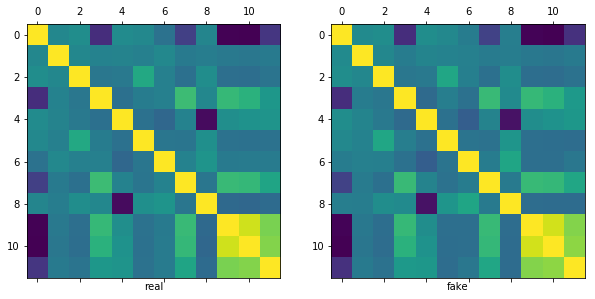

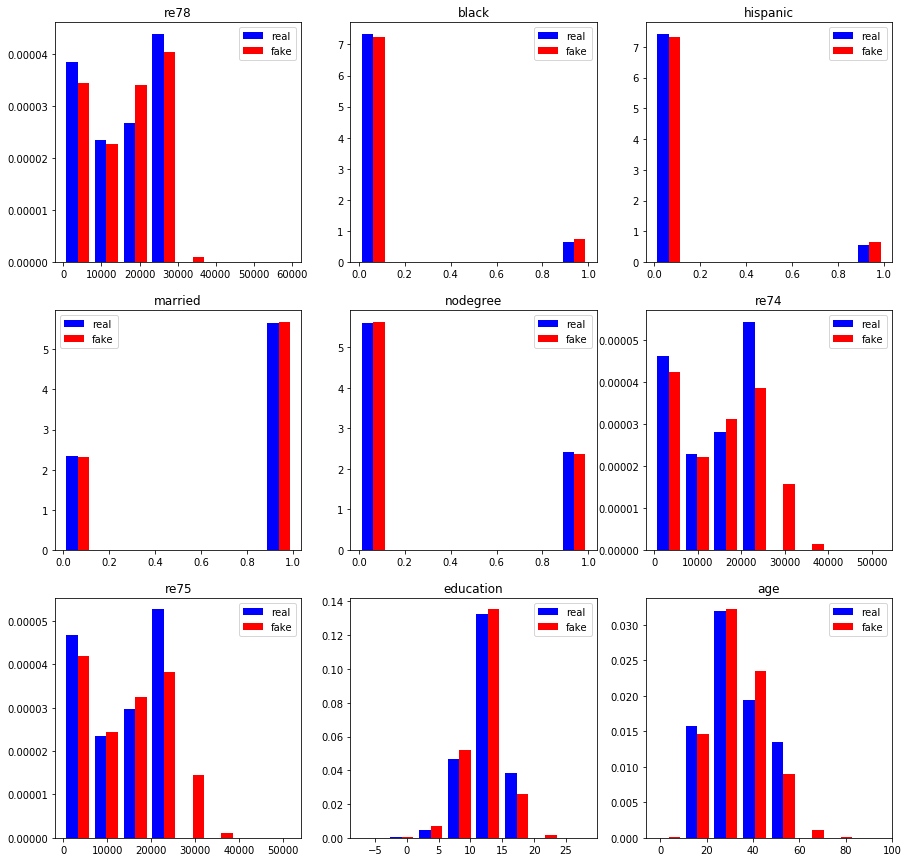

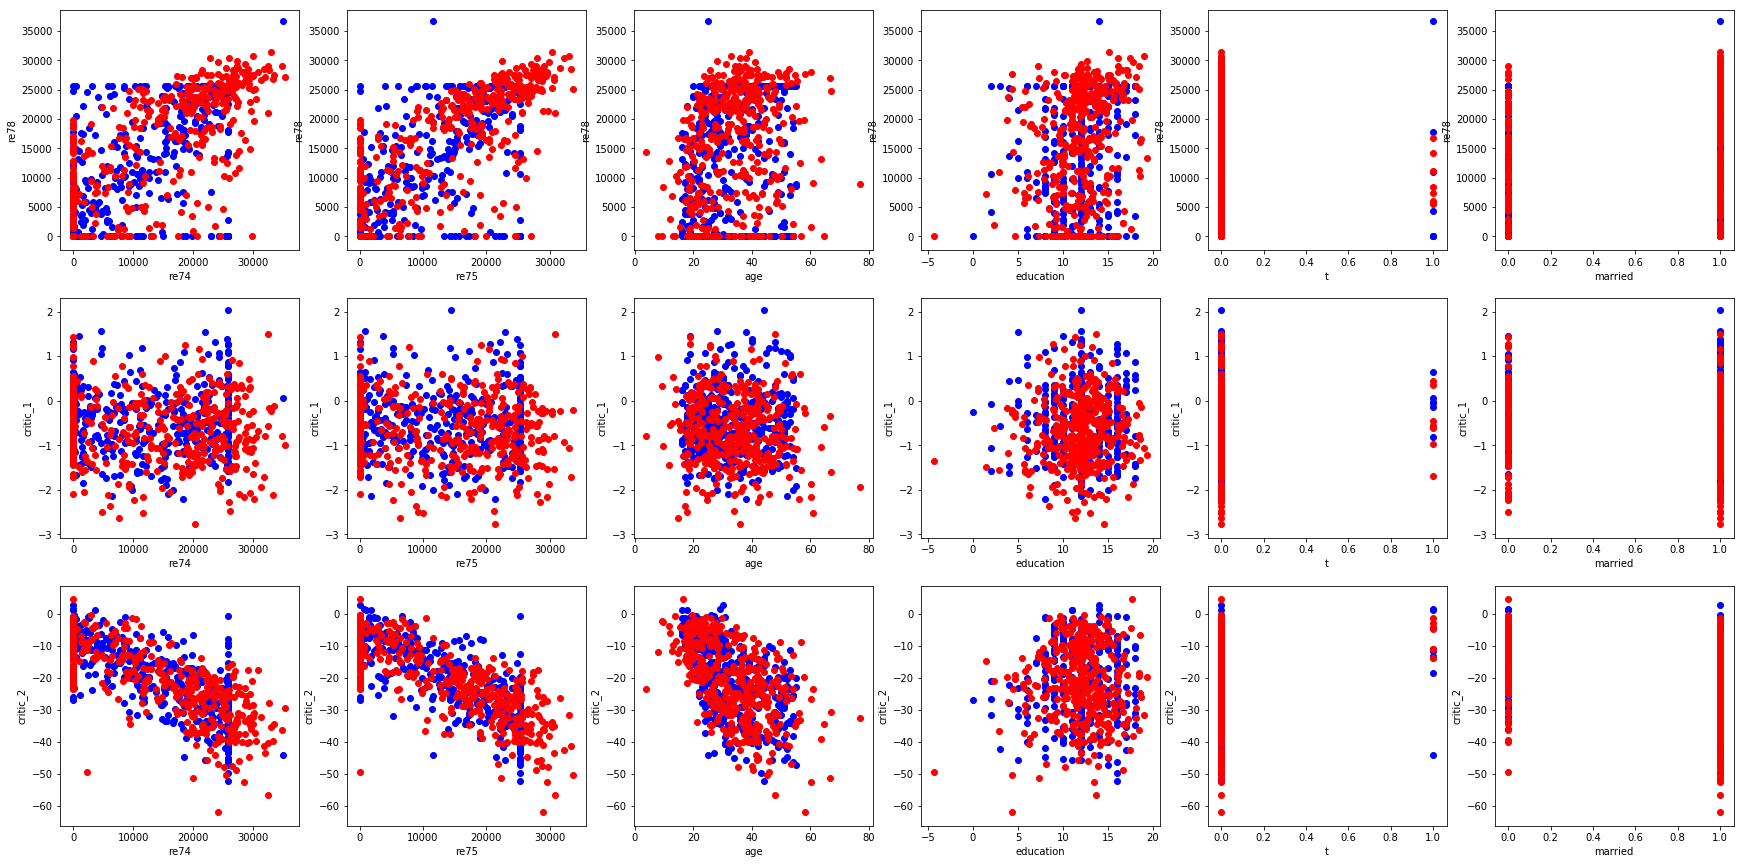

In [0]:
df_real, df_fake = apply_models_to_data()
evaluate_results()

In [0]:
# save trained model parameters
save_trained_parameters("cps")

In [0]:
# generate and save data
save_generated_data("cps",int(1e6))

mkdir: cannot create directory ‘data/generated’: File exists


# PSID Data

Let's repeat the same steps as before with the PSID data.

In [0]:
# Load data and setup everything
file = "data/original_data/psid.feather"
df = pd.read_feather(file).drop(["u74", "u75"], axis=1)
df_balanced = df.sample(2*len(df), weights=(1-df.t.mean())*df.t+df.t.mean()*(1-df.t), replace=True, random_state=0)

#First X|t
data_wrapper1 = wgan.DataWrapper(df_balanced, continuous_vars1, categorical_vars1, 
                                 context_vars1, continuous_lower_bounds1)
x1, context1 = data_wrapper1.preprocess(df_balanced)
specifications1 = wgan.Specifications(data_wrapper1,batch_size=2048,max_epochs=1000,print_every=200)

generator1 = wgan.Generator(specifications1)
critic1 = wgan.Critic(specifications1)

#Then Y|X,t
data_wrapper2 = wgan.DataWrapper(df_balanced, continuous_vars = continuous_vars2, 
                                 context_vars= context_vars2, continuous_lower_bounds = continuous_lower_bounds2)
x2, context2 = data_wrapper2.preprocess(df_balanced)
specifications2 = wgan.Specifications(data_wrapper2,batch_size=2048,max_epochs=1000,print_every=200)

generator2 = wgan.Generator(specifications2)
critic2 = wgan.Critic(specifications2)

G=[generator1,generator2]
C=[critic1,critic2]
data_wrappers = [data_wrapper1,data_wrapper2]

settings: {'device': 'cuda', 'print_every': 200, 'save_every': 100, 'save_checkpoint': None, 'load_checkpoint': None, 'test_set_size': 16, 'batch_size': 2048, 'max_epochs': 1000, 'optimizer': 'AdamHD', 'generator_d_noise': 12, 'generator_lr': 0.0001, 'generator_dropout': 0.1, 'generator_d_hidden': [128, 128, 128], 'critic_gp_factor': 5, 'critic_lr': 0.0001, 'critic_steps': 15, 'critic_dropout': 0.1, 'critic_d_hidden': [128, 128, 128]}
settings: {'device': 'cuda', 'print_every': 200, 'save_every': 100, 'save_checkpoint': None, 'load_checkpoint': None, 'test_set_size': 16, 'batch_size': 2048, 'max_epochs': 1000, 'optimizer': 'AdamHD', 'generator_d_noise': 1, 'generator_lr': 0.0001, 'generator_dropout': 0.1, 'generator_d_hidden': [128, 128, 128], 'critic_gp_factor': 5, 'critic_lr': 0.0001, 'critic_steps': 15, 'critic_dropout': 0.1, 'critic_d_hidden': [128, 128, 128]}


Either train the model from scratch with the next cell, or use our pre-trained parameters via the subsequent cell.

In [0]:
# Option 1: train from scratch
wgan.train(generator1, critic1, x1, context1, specifications1)
wgan.train(generator2, critic2, x2, context2, specifications2)

epoch 0 | step 4 | WD_test 1.04 | WD_train 1.22 | sec passed 0 |
epoch 200 | step 604 | WD_test 0.77 | WD_train 0.95 | sec passed 14 |
epoch 400 | step 1204 | WD_test 0.76 | WD_train 0.76 | sec passed 14 |
epoch 600 | step 1804 | WD_test 0.55 | WD_train 0.67 | sec passed 15 |
epoch 800 | step 2404 | WD_test 0.52 | WD_train 0.63 | sec passed 15 |
epoch 0 | step 4 | WD_test 0.15 | WD_train 0.27 | sec passed 0 |
epoch 200 | step 604 | WD_test -0.17 | WD_train 0.14 | sec passed 14 |
epoch 400 | step 1204 | WD_test -0.01 | WD_train 0.12 | sec passed 14 |
epoch 600 | step 1804 | WD_test 0.12 | WD_train 0.12 | sec passed 14 |
epoch 800 | step 2404 | WD_test -0.03 | WD_train 0.13 | sec passed 14 |


In [0]:
# Option 2: load trained model parameters
load_saved_parameters("psid")

--------------------att--------------------
att = 1019.55206 | se = 26.362203483049804
-------------comparison of means-------------
t               0.0                    1.0         
source         fake          real     fake     real
critic_2     -27.82    -28.469999   -14.24   -13.80
critic_1      -0.41     -0.130000    -0.50    -0.30
age           36.49     34.850000    26.91    25.82
education     11.43     12.120000     9.81    10.35
black          0.29      0.250000     0.85     0.84
hispanic       0.03      0.030000     0.03     0.06
married        0.85      0.870000     0.19     0.19
nodegree       0.33      0.310000     0.71     0.71
re74       18012.39  19428.750000  1820.51  2095.57
re75       16722.92  19063.340000   942.36  1532.06
re78       19265.78  21553.920000  5130.97  6349.14
-------------comparison of stds-------------
t               0.0                1.0         
source         fake      real     fake     real
critic_2      10.50     11.83     6.04     5.68
cr

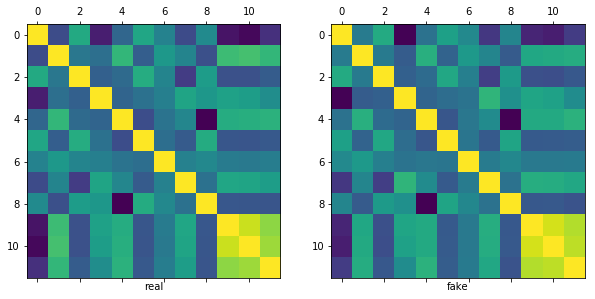

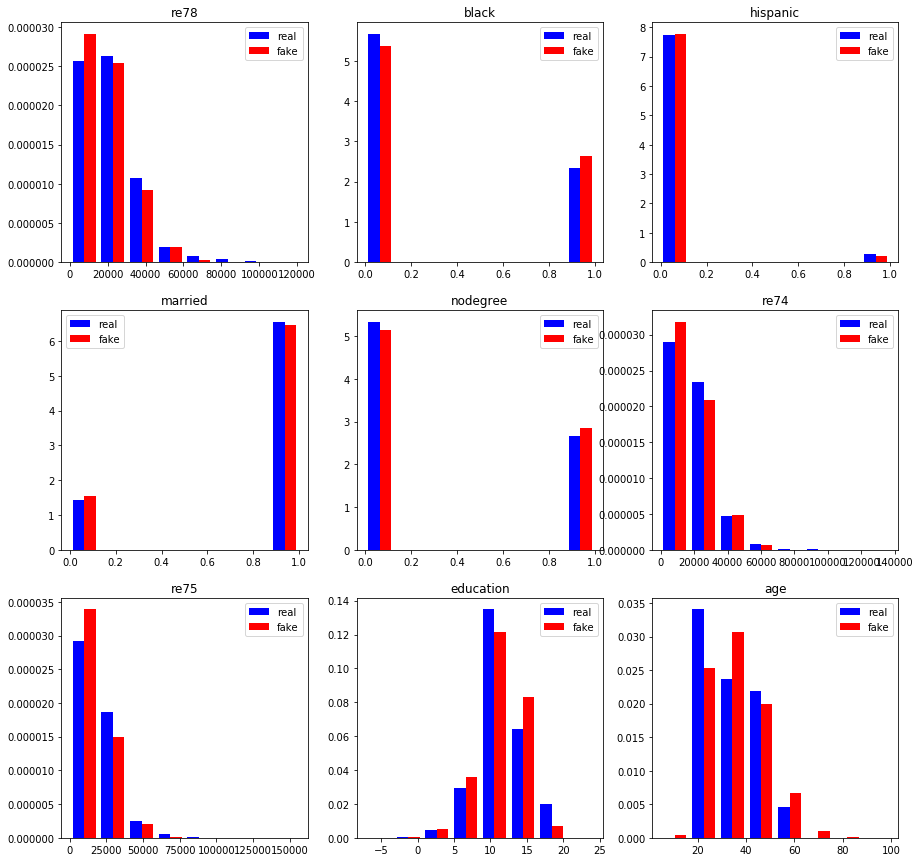

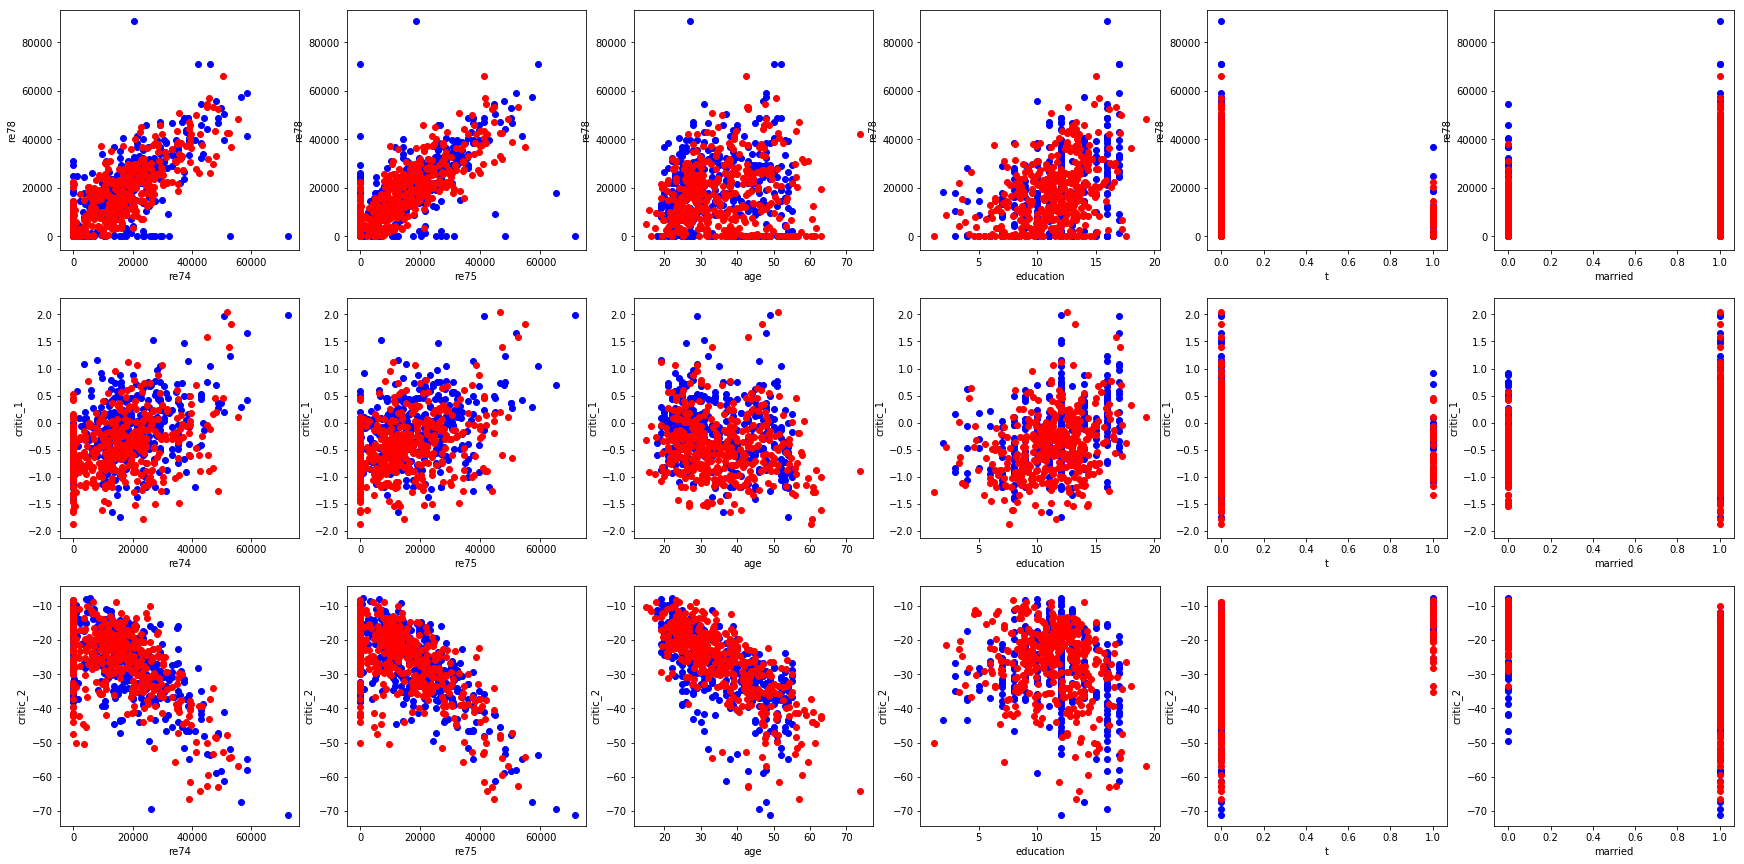

In [0]:
# Evaluation
df_real, df_fake = apply_models_to_data()
evaluate_results()

In [0]:
# save trained model parameters
save_trained_parameters("psid")

In [0]:
# generate and save data
save_generated_data("psid",int(1e6))

mkdir: cannot create directory ‘data/generated’: File exists
